# Functions

In [3]:
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Set the device to the first available GPU
    device = torch.device("cuda:0")
else:
    # If GPU is not available, use the CPU
    device = torch.device("cpu")

In [6]:
class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim, hidden_dim) if i == 0 else nn.GRUCell(hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm outside GRU cells

        
        
    def forward(self, x, h=None):
        if h is None:
            h = [torch.zeros(x.size(0), self.hidden_dim) for _ in range(self.num_layers)]
        
        hidden_states = []
        
        for t in range(x.size(1)):
            input_t = x[:, t, :]
            new_hidden_states = []
            for layer_idx, gru_cell in enumerate(self.gru_cells):
                h[layer_idx] = gru_cell(input_t, h[layer_idx])
                new_hidden_states.append(h[layer_idx])
                input_t = h[layer_idx]  # Update input_t with the new hidden state for the next layer
            hidden_states.append(new_hidden_states)
        
        last_hidden_states = [layer_states[-1] for layer_states in hidden_states]
        # Apply BatchNorm to the last hidden state
        last_hidden_states[-1] = self.batch_norm(last_hidden_states[-1])
        out = self.fc(last_hidden_states[-1])
        out = torch.sigmoid(out)
        
        return out, last_hidden_states 

In [7]:
# Custom Dataset class for loading data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Implement data retrieval for each index
        input_data = self.X[idx]
        target_data = self.y[idx]
        input_data = input_data.unsqueeze(0)
        
        # Convert data to torch tensors if required
        input_tensor = torch.Tensor(input_data)
        target_tensor = torch.Tensor(target_data)
        
        return input_tensor, target_tensor

In [8]:
def accuracy(correct, total):
    return float(correct)/total

In [9]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device)
    model.train()
    predicted_probs = []
    predicted_labels = []
    hidden_states = []
    for x, y in dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        hidden_states_batch = []  # Initialize a list to store hidden states for the current batch        
        out, last_hidden_states = model(x)
        #y_prob = torch.sigmoid(out)
        # Append the predicted probabilities to the list
        predicted_probs.append(out.cpu().detach().numpy())
        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())

        #hidden_states.append(hidden)
        
        y_pred = torch.round(out)
        # Append the batch's hidden states to the list
        for layer_state in last_hidden_states:
            hidden_states_batch.append(layer_state.cpu().detach().numpy())
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        # Append the batch's hidden states to the overall hidden_states list
        hidden_states.append(hidden_states_batch)
        
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        predicted_labels.extend(zip(y_pred.cpu().detach().cpu().numpy(), y.cpu().numpy()))
        if scheduler:
            scheduler.step(loss)
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs 

In [10]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device).float()
    model.eval()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            
            out, last_hidden_states = model(x)
            
            loss = loss_fn(out, y)
            epoch_loss.append(loss.item())

            #hidden_states.append(hidden)
            #y_pred = torch.sigmoid(out)
            predicted_probs.append(out.cpu().detach().numpy())
            y_pred = torch.round(out)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
            predicted_labels.extend(zip(y_pred.cpu().numpy(), y.cpu().numpy()))
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs

In [11]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    #train_hidden_states, val_hidden_states = [], []
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, train_preds, train_probs = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        #train_hidden_states.extend(train_hidden)
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc, val_preds, val_probs = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            #val_hidden_states.extend(val_hidden)
        
        #if isinstance(scheduler, ReduceLROnPlateau):
        #    scheduler.step(epoch_train_acc if schedule_on_train or val_dataloader is None else epoch_val_acc)
            
        if epoch % 10 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
        if epoch == num_epochs - 1:  # Store values only for the final epoch
            train_predicted_labels = train_preds
            #val_predicted_labels = val_preds
            train_probs_final = train_probs
            #val_probs_final = val_probs
            if val_dataloader is not None:
                val_predicted_labels = val_preds
                val_probs_final = val_probs

    if val_dataloader is not None:        
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, val_predicted_labels, train_probs_final, val_probs_final
    else: 
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final

# Training & Gradients

# S Model

In [12]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial','s_1','s_2','s_3','s_4']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns

In [13]:
input_dim = 42
hidden_dim = 32
output_dim = 4
num_layers = 1
n_epochs =100
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)

In [14]:
#hidden_states_all = []
hidden_states_dict = {}
predictions_dict_s = {}

for j in np.arange(1,16):
    for i in np.arange(0,151,10):
        shift = i
        set_values = j
        model_name = 'm'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        #print(X_train.columns)
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
        #print(X_train.columns)
        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
        #print(X_train.shape[0])
        break 

        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        
        
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        #torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
        

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()
        # Construct the key for the combination
        key = f"sm_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        predictions_dict_s[key] = all_preds_array 

        print(str(model_name)+":"+str(np.mean(accuracies)))
        #print(np.mean(accuracies))

In [15]:
X_test

,nose_x_minus_0,nose_y_minus_0,nose_z_minus_0,headTop_x_minus_0,headTop_y_minus_0,headTop_z_minus_0,neck_x_minus_0,neck_y_minus_0,neck_z_minus_0,tailBase_x_minus_0,...,rShoulder_z_minus_0,rElbow_x_minus_0,rElbow_y_minus_0,rElbow_z_minus_0,rWrist_x_minus_0,rWrist_y_minus_0,rWrist_z_minus_0,rHip_x_minus_0,rHip_y_minus_0,rHip_z_minus_0
0,0.992424,0.308649,0.082163,0.990544,0.306182,0.069202,0.680216,0.680452,0.298350,0.523622,...,0.194278,0.644827,0.801731,0.294888,0.942811,0.559542,0.005711,0.904557,0.286315,0.555584
1,0.994032,0.309651,0.095691,0.991373,0.307898,0.079724,0.680216,0.680452,0.298350,0.523622,...,0.194278,0.644827,0.801731,0.294888,0.951420,0.556438,0.037989,0.909514,0.288051,0.572342
2,0.994173,0.308851,0.105475,0.991240,0.306524,0.093486,0.680216,0.680452,0.298350,0.523622,...,0.194278,0.644827,0.801731,0.294888,0.944422,0.558108,0.012790,0.907858,0.286922,0.580780
3,0.993401,0.308509,0.115696,0.990055,0.304723,0.101481,0.680216,0.680452,0.298350,0.523622,...,0.194278,0.644827,0.801731,0.294888,0.955558,0.552209,0.047405,0.908970,0.279935,0.590063
4,0.989208,0.307988,0.111972,0.986981,0.305345,0.099828,0.680216,0.680452,0.298350,0.523622,...,0.194278,0.644827,0.801731,0.294888,0.949498,0.555112,0.039332,0.909778,0.282390,0.579076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.907247,0.087380,0.659840,0.920664,0.258440,0.334099,0.877547,0.140975,0.708923,0.724598,...,0.121546,0.851432,0.578375,0.079546,0.873606,0.501248,0.200201,0.868922,0.289443,0.247519
331,0.907247,0.087380,0.659840,0.920664,0.258440,0.334099,0.877547,0.140975,0.708923,0.786231,...,0.311583,0.874863,0.566481,0.139293,0.873606,0.501248,0.200201,0.769215,0.257287,0.254733
332,0.907247,0.087380,0.659840,0.920664,0.258440,0.334099,0.877547,0.140975,0.708923,0.804440,...,0.251797,0.861163,0.559267,0.098306,0.924168,0.606511,0.035104,0.774344,0.268751,0.431135
333,0.907247,0.087380,0.659840,0.920664,0.258440,0.334099,0.932470,0.350541,0.000000,0.793883,...,0.050738,0.864692,0.540585,0.118714,0.909071,0.585437,0.057599,0.776229,0.279005,0.051032


In [43]:
X.shape

(6736, 42)

In [16]:
file = "y_tilda_mirror.csv"
y_tilda_org = pd.read_csv(file)

In [42]:
X_test

,nose_x_minus_10,nose_y_minus_10,nose_z_minus_10,headTop_x_minus_10,headTop_y_minus_10,headTop_z_minus_10,neck_x_minus_10,neck_y_minus_10,neck_z_minus_10,tailBase_x_minus_10,...,rShoulder_z_minus_10,rElbow_x_minus_10,rElbow_y_minus_10,rElbow_z_minus_10,rWrist_x_minus_10,rWrist_y_minus_10,rWrist_z_minus_10,rHip_x_minus_10,rHip_y_minus_10,rHip_z_minus_10
0,0.970588,0.323506,0.018531,0.970556,0.320071,0.010588,0.998165,0.326123,0.299834,0.900378,...,0.293372,0.913258,0.566218,0.149958,0.927148,0.569240,0.019150,0.874006,0.303179,0.514884
1,0.971247,0.321409,0.034808,0.968944,0.316992,0.022011,0.998165,0.326123,0.299834,0.904044,...,0.293372,0.912572,0.556945,0.158647,0.923716,0.568034,0.033237,0.876957,0.298164,0.533691
2,0.970093,0.318294,0.051892,0.967167,0.314304,0.041226,0.998165,0.326123,0.299834,0.908947,...,0.293372,0.911319,0.553152,0.168552,0.918986,0.576080,0.020840,0.877541,0.293674,0.546340
3,0.968800,0.316651,0.073045,0.964478,0.312612,0.062249,0.998165,0.326123,0.299834,0.908466,...,0.293372,0.918251,0.549607,0.202545,0.915062,0.573192,0.032460,0.878950,0.290393,0.561498
4,0.964390,0.313687,0.097908,0.960483,0.308426,0.087612,0.998165,0.326123,0.299834,0.908387,...,0.293372,0.911021,0.543550,0.212929,0.921984,0.571639,0.063765,0.878661,0.287158,0.566016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.896207,0.290068,0.639812,0.893998,0.281747,0.640716,0.855151,0.143111,0.825096,0.920852,...,0.778273,0.895181,0.207348,0.810070,0.767754,0.204623,0.914789,0.908373,0.113812,0.705596
147,0.910321,0.306911,0.600376,0.906535,0.296332,0.608949,0.855151,0.143111,0.825096,0.920852,...,0.773742,0.909292,0.200673,0.778158,0.767754,0.204623,0.914789,0.913173,0.108930,0.753712
148,0.928688,0.319475,0.589238,0.923302,0.301761,0.595294,0.855151,0.143111,0.825096,0.920852,...,0.759832,0.919415,0.211751,0.783339,0.767754,0.204623,0.914789,0.916566,0.108812,0.760239
149,0.925568,0.315677,0.532590,0.922040,0.301839,0.548475,0.855151,0.143111,0.825096,0.920852,...,0.737487,0.886517,0.197463,0.797462,0.767754,0.204623,0.914789,0.913234,0.109824,0.739128


In [29]:
for i in np.arange(1,16):
    shift = 10
    set_values = i
    k = 0+15*(set_values-1)
    print(shift,set_values,k)
    model_name = 'm_'+str(shift)+'_'+'val'+str(set_values)+'_gt'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    #print(X_train.columns)
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)
        
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_test[new_col_name] = y_test[col].shift(shift)
        
    y_test = y_test.dropna()
    #print(y_tilda.columns)
    y_test = y_test.drop(columns=['s_1', 's_2', 's_3', 's_4'])

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {('s_1_minus_'+str(shift)): 's_1',
                        ('s_2_minus_'+str(shift)): 's_2',
                        ('s_3_minus_'+str(shift)): 's_3',
                        ('s_4_minus_'+str(shift)): 's_4'}
    y_test = y_test.rename(columns=new_column_names)
    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.to_numpy()
    y_test = torch.tensor(y_test.values, dtype=torch.float32)
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_s.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_s[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = torch.tensor(y_hat, dtype=torch.float32).clone().detach().requires_grad_(True)
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()

    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    loss = loss_fn(output,y_test) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)
    #predictions_dict_sm[key] = input_gradients
    lWrist_x_gradient = input_gradients[:,21].numpy()
    rWrist_x_gradient = input_gradients[:,-10].numpy()
    plt.figure()
    plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
    plt.plot(lWrist_x_gradient,label='left_wrist')
    plt.plot(rWrist_x_gradient,label='right_wrist')
    plt.legend()
    plot_name = 'trial'+str(set_values)+'_m_only'+'shift'+str(shift)+'_testplot.jpg'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)

10 1 0


ValueError: Target size (torch.Size([141, 4])) must be the same as input size (torch.Size([151, 4]))

In [36]:
X_test.columns

Index(['nose_x_minus_10', 'nose_y_minus_10', 'nose_z_minus_10',
       'headTop_x_minus_10', 'headTop_y_minus_10', 'headTop_z_minus_10',
       'neck_x_minus_10', 'neck_y_minus_10', 'neck_z_minus_10',
       'tailBase_x_minus_10', 'tailBase_y_minus_10', 'tailBase_z_minus_10',
       'lEar_x_minus_10', 'lEar_y_minus_10', 'lEar_z_minus_10',
       'lShoulder_x_minus_10', 'lShoulder_y_minus_10', 'lShoulder_z_minus_10',
       'lElbow_x_minus_10', 'lElbow_y_minus_10', 'lElbow_z_minus_10',
       'lWrist_x_minus_10', 'lWrist_y_minus_10', 'lWrist_z_minus_10',
       'lHip_x_minus_10', 'lHip_y_minus_10', 'lHip_z_minus_10',
       'rEar_x_minus_10', 'rEar_y_minus_10', 'rEar_z_minus_10',
       'rShoulder_x_minus_10', 'rShoulder_y_minus_10', 'rShoulder_z_minus_10',
       'rElbow_x_minus_10', 'rElbow_y_minus_10', 'rElbow_z_minus_10',
       'rWrist_x_minus_10', 'rWrist_y_minus_10', 'rWrist_z_minus_10',
       'rHip_x_minus_10', 'rHip_y_minus_10', 'rHip_z_minus_10'],
      dtype='object')

In [41]:
X_test = X_test.dropna()
X_test

,nose_x_minus_10,nose_y_minus_10,nose_z_minus_10,headTop_x_minus_10,headTop_y_minus_10,headTop_z_minus_10,neck_x_minus_10,neck_y_minus_10,neck_z_minus_10,tailBase_x_minus_10,...,rShoulder_z_minus_10,rElbow_x_minus_10,rElbow_y_minus_10,rElbow_z_minus_10,rWrist_x_minus_10,rWrist_y_minus_10,rWrist_z_minus_10,rHip_x_minus_10,rHip_y_minus_10,rHip_z_minus_10
0,0.970588,0.323506,0.018531,0.970556,0.320071,0.010588,0.998165,0.326123,0.299834,0.900378,...,0.293372,0.913258,0.566218,0.149958,0.927148,0.569240,0.019150,0.874006,0.303179,0.514884
1,0.971247,0.321409,0.034808,0.968944,0.316992,0.022011,0.998165,0.326123,0.299834,0.904044,...,0.293372,0.912572,0.556945,0.158647,0.923716,0.568034,0.033237,0.876957,0.298164,0.533691
2,0.970093,0.318294,0.051892,0.967167,0.314304,0.041226,0.998165,0.326123,0.299834,0.908947,...,0.293372,0.911319,0.553152,0.168552,0.918986,0.576080,0.020840,0.877541,0.293674,0.546340
3,0.968800,0.316651,0.073045,0.964478,0.312612,0.062249,0.998165,0.326123,0.299834,0.908466,...,0.293372,0.918251,0.549607,0.202545,0.915062,0.573192,0.032460,0.878950,0.290393,0.561498
4,0.964390,0.313687,0.097908,0.960483,0.308426,0.087612,0.998165,0.326123,0.299834,0.908387,...,0.293372,0.911021,0.543550,0.212929,0.921984,0.571639,0.063765,0.878661,0.287158,0.566016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.896207,0.290068,0.639812,0.893998,0.281747,0.640716,0.855151,0.143111,0.825096,0.920852,...,0.778273,0.895181,0.207348,0.810070,0.767754,0.204623,0.914789,0.908373,0.113812,0.705596
147,0.910321,0.306911,0.600376,0.906535,0.296332,0.608949,0.855151,0.143111,0.825096,0.920852,...,0.773742,0.909292,0.200673,0.778158,0.767754,0.204623,0.914789,0.913173,0.108930,0.753712
148,0.928688,0.319475,0.589238,0.923302,0.301761,0.595294,0.855151,0.143111,0.825096,0.920852,...,0.759832,0.919415,0.211751,0.783339,0.767754,0.204623,0.914789,0.916566,0.108812,0.760239
149,0.925568,0.315677,0.532590,0.922040,0.301839,0.548475,0.855151,0.143111,0.825096,0.920852,...,0.737487,0.886517,0.197463,0.797462,0.767754,0.204623,0.914789,0.913234,0.109824,0.739128


In [13]:
DUPA 

NameError: name 'DUPA' is not defined

# SM model

In [ ]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns

In [ ]:
scaled_df.shape[1]-2

46

In [ ]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =100
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)

In [ ]:
#hidden_states_all = []
hidden_states_dict = {}
predictions_dict_sm = {}

for j in np.arange(1,16):
    for i in np.arange(10,151,10):
        shift = i
        set_values = j
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        #print(X_train.columns)
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
        #print(X_train.columns)
        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
        #print(X_train.shape[0])
        

        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        
        
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        #torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
        

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()
        # Construct the key for the combination
        key = f"sm_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        predictions_dict_sm[key] = all_preds_array 

        print(model_name)
        print(np.mean(accuracies))

Epoch 0, train loss: 0.8925386667251587, train acc: 0.5095671981776765
Epoch 10, train loss: 0.6956508755683899, train acc: 0.9744495064540623
Epoch 20, train loss: 0.6412665247917175, train acc: 0.9844343204252088
Epoch 30, train loss: 0.6288592219352722, train acc: 0.9844343204252088
Epoch 40, train loss: 0.6261427402496338, train acc: 0.9844343204252088
Epoch 50, train loss: 0.6253336668014526, train acc: 0.9844343204252088
Epoch 60, train loss: 0.6250009536743164, train acc: 0.9844343204252088
Epoch 70, train loss: 0.6248315572738647, train acc: 0.9844343204252088
Epoch 80, train loss: 0.6247270703315735, train acc: 0.9844343204252088
Epoch 90, train loss: 0.6246582269668579, train acc: 0.9844343204252088
s_m10_val1_gates
0.814569536423841
Epoch 0, train loss: 0.6357592344284058, train acc: 0.9681923972071373
Epoch 10, train loss: 0.6357163786888123, train acc: 0.9681923972071373
Epoch 20, train loss: 0.6356725692749023, train acc: 0.9681923972071373
Epoch 30, train loss: 0.6355464

In [ ]:
first_key = next(iter(predictions_dict_sm))  # Get the first key
y_hat = predictions_dict_sm[first_key]

In [ ]:
# Create an empty DataFrame to store the shifted data
file = "y_tilda.csv"
y_tilda = pd.read_csv(file)
y_tilda = y_tilda[y_tilda['trial']==12].drop(columns=['trial','id'])
shift = 10 
col_shift = ['s_1', 's_2', 's_3', 's_4']
# Loop through unique trial values
    # Create shifted columns for each column in columns_to_shift
for col in col_shift:
    new_col_name = col + '_minus_' + str(shift)
    y_tilda[new_col_name] = y_tilda[col].shift(shift)

# Drop the last 'i' records for each trial
y_tilda = y_tilda.dropna()
print(y_tilda.columns)
y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
new_column_names = {'s_1_minus_10': 's_1',
                    's_2_minus_10': 's_2',
                    's_3_minus_10': 's_3',
                    's_4_minus_10': 's_4'}

y_tilda = y_tilda.rename(columns=new_column_names)
y_tilda = y_tilda.to_numpy()
print(y_tilda.shape)
y_tilda = torch.tensor(y_tilda)
y_hat = torch.tensor(y_hat, dtype=torch.float32, requires_grad=True)
y_tilda = torch.tensor(y_tilda, dtype=torch.float32, requires_grad=True)
#y_hat = torch.tensor(y_hat)

Index(['s_1', 's_2', 's_3', 's_4', 's_1_minus_10', 's_2_minus_10',
       's_3_minus_10', 's_4_minus_10'],
      dtype='object')
(340, 4)


C:\Users\kacpe\AppData\Local\Temp\ipykernel_3436\3148207042.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat = torch.tensor(y_hat, dtype=torch.float32, requires_grad=True)
C:\Users\kacpe\AppData\Local\Temp\ipykernel_3436\3148207042.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tilda = torch.tensor(y_tilda, dtype=torch.float32, requires_grad=True)


In [ ]:
keys_list

['sm_shift10_set1',
 'sm_shift20_set1',
 'sm_shift30_set1',
 'sm_shift40_set1',
 'sm_shift50_set1',
 'sm_shift60_set1',
 'sm_shift70_set1',
 'sm_shift80_set1',
 'sm_shift90_set1',
 'sm_shift100_set1',
 'sm_shift110_set1',
 'sm_shift120_set1',
 'sm_shift130_set1',
 'sm_shift140_set1',
 'sm_shift150_set1',
 'sm_shift10_set2',
 'sm_shift20_set2',
 'sm_shift30_set2',
 'sm_shift40_set2',
 'sm_shift50_set2',
 'sm_shift60_set2',
 'sm_shift70_set2',
 'sm_shift80_set2',
 'sm_shift90_set2',
 'sm_shift100_set2',
 'sm_shift110_set2',
 'sm_shift120_set2',
 'sm_shift130_set2',
 'sm_shift140_set2',
 'sm_shift150_set2',
 'sm_shift10_set3',
 'sm_shift20_set3',
 'sm_shift30_set3',
 'sm_shift40_set3',
 'sm_shift50_set3',
 'sm_shift60_set3',
 'sm_shift70_set3',
 'sm_shift80_set3',
 'sm_shift90_set3',
 'sm_shift100_set3',
 'sm_shift110_set3',
 'sm_shift120_set3',
 'sm_shift130_set3',
 'sm_shift140_set3',
 'sm_shift150_set3',
 'sm_shift10_set4',
 'sm_shift20_set4',
 'sm_shift30_set4',
 'sm_shift40_set4',
 '

In [ ]:
print(keys_list)

['sm_shift10_set1', 'sm_shift20_set1', 'sm_shift30_set1', 'sm_shift40_set1', 'sm_shift50_set1', 'sm_shift60_set1', 'sm_shift70_set1', 'sm_shift80_set1', 'sm_shift90_set1', 'sm_shift100_set1', 'sm_shift110_set1', 'sm_shift120_set1', 'sm_shift130_set1', 'sm_shift140_set1', 'sm_shift150_set1', 'sm_shift10_set2', 'sm_shift20_set2', 'sm_shift30_set2', 'sm_shift40_set2', 'sm_shift50_set2', 'sm_shift60_set2', 'sm_shift70_set2', 'sm_shift80_set2', 'sm_shift90_set2', 'sm_shift100_set2', 'sm_shift110_set2', 'sm_shift120_set2', 'sm_shift130_set2', 'sm_shift140_set2', 'sm_shift150_set2', 'sm_shift10_set3', 'sm_shift20_set3', 'sm_shift30_set3', 'sm_shift40_set3', 'sm_shift50_set3', 'sm_shift60_set3', 'sm_shift70_set3', 'sm_shift80_set3', 'sm_shift90_set3', 'sm_shift100_set3', 'sm_shift110_set3', 'sm_shift120_set3', 'sm_shift130_set3', 'sm_shift140_set3', 'sm_shift150_set3', 'sm_shift10_set4', 'sm_shift20_set4', 'sm_shift30_set4', 'sm_shift40_set4', 'sm_shift50_set4', 'sm_shift60_set4', 'sm_shift70_

In [ ]:
# Create an empty DataFrame to store the shifted data
file = "y_tilda_mirror.csv"
y_tilda_org = pd.read_csv(file)
gradients = {}
import itertools as it 


for j, k in enumerate(np.arange(1, 226, 15), start=1):
    for i in np.arange(10, 151, 10):
        if i == 150:
            print(i, j, k)
            break
        print(i, j, k)
        k+=1
        shift = i
        set_values = j
        #k = t+t-j+i//10
        print(i,j,k)
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        #print(X_train.columns)
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        y_tilda = y_tilda_org[y_tilda_org['trial']==j].drop(columns=['trial','id'])
        col_shift = ['s_1', 's_2', 's_3', 's_4']
        # Loop through unique trial values
            # Create shifted columns for each column in columns_to_shift
        for col in col_shift:
            new_col_name = col + '_minus_' + str(shift)
            y_tilda[new_col_name] = y_tilda[col].shift(shift)

        # Drop the last 'i' records for each trial
        y_tilda = y_tilda.dropna()
        #print(y_tilda.columns)
        y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
        new_column_names = {'s_1_minus_10': 's_1',
                            's_2_minus_10': 's_2',
                            's_3_minus_10': 's_3',
                            's_4_minus_10': 's_4'}

        y_tilda = y_tilda.rename(columns=new_column_names)
        y_tilda = y_tilda.to_numpy()
        # Convert the dictionary keys into a list
        keys_list = list(predictions_dict_sm.keys())
        #print(keys_list)
        # Access the second key (index 1 in the list)
        trial_key = keys_list[k]
        y_hat = predictions_dict_sm[trial_key]
        # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
        y_hat = y_hat.clone().detach().requires_grad_(True).float()
        #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
        y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

        y_hat = y_hat.requires_grad_(True)
        y_tilda = y_tilda.requires_grad_(True)

        # Define the loss function
        #loss_fn = nn.BCELoss()

        # Calculate the loss
        input = torch.tensor(X_test.values)
        input = input.unsqueeze(1)
        input = input.float()
        # set input to require_grad
        input = input.requires_grad_(True)
        model.eval()
        output, f = model(input)

        # calculating loss 
        output = output.requires_grad_(True)
        #loss_fn = nn.BCEWithLogitsLoss()
        class_weights = torch.tensor([1.8]).to(device)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        loss = loss_fn(output,y_tilda) 
        loss.backward()
        #print(input)

        # Access the gradients for the input data
        key = f"sm_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        input_gradients = input.grad.squeeze(1)
        predictions_dict_sm[key] = input_gradients
        #print(input_gradients)

10 1 1
10 1 2
20 1 2
20 1 3
30 1 3
30 1 4
40 1 4
40 1 5
50 1 5
50 1 6
60 1 6
60 1 7
70 1 7
70 1 8
80 1 8
80 1 9
90 1 9
90 1 10
100 1 10
100 1 11
110 1 11
110 1 12
120 1 12
120 1 13
130 1 13
130 1 14
140 1 14
140 1 15
150 1 15
10 2 16
10 2 17
20 2 17
20 2 18
30 2 18
30 2 19
40 2 19
40 2 20
50 2 20
50 2 21
60 2 21
60 2 22
70 2 22
70 2 23
80 2 23
80 2 24
90 2 24
90 2 25
100 2 25
100 2 26
110 2 26
110 2 27
120 2 27
120 2 28
130 2 28
130 2 29
140 2 29
140 2 30
150 2 30
10 3 31
10 3 32
20 3 32
20 3 33
30 3 33
30 3 34
40 3 34
40 3 35
50 3 35
50 3 36
60 3 36
60 3 37
70 3 37
70 3 38
80 3 38
80 3 39
90 3 39
90 3 40
100 3 40
100 3 41
110 3 41
110 3 42
120 3 42
120 3 43
130 3 43
130 3 44
140 3 44
140 3 45
150 3 45
10 4 46
10 4 47


KeyboardInterrupt: 

In [ ]:
# Create an empty DataFrame to store the shifted data
file = "y_tilda.csv"
y_tilda = pd.read_csv(file)
y_tilda = y_tilda[y_tilda['trial']==12].drop(columns=['trial','id'])
shift = 10 
col_shift = ['s_1', 's_2', 's_3', 's_4']
# Loop through unique trial values
    # Create shifted columns for each column in columns_to_shift
for col in col_shift:
    new_col_name = col + '_minus_' + str(shift)
    y_tilda[new_col_name] = y_tilda[col].shift(shift)

# Drop the last 'i' records for each trial
y_tilda = y_tilda.dropna()
print(y_tilda.columns)
y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
new_column_names = {'s_1_minus_10': 's_1',
                    's_2_minus_10': 's_2',
                    's_3_minus_10': 's_3',
                    's_4_minus_10': 's_4'}

y_tilda = y_tilda.rename(columns=new_column_names)
y_tilda = y_tilda.to_numpy()
print(y_tilda.shape)
y_tilda = torch.tensor(y_tilda)
y_hat = torch.tensor(y_hat, dtype=torch.float32, requires_grad=True)
y_tilda = torch.tensor(y_tilda, dtype=torch.float32, requires_grad=True)

In [ ]:
lWrist_x_gradient = input_gradients[:,21].numpy()
rWrist_x_gradient = input_gradients[:,-10].numpy()

In [ ]:
rWrist_x_gradient

array([-8.9846378e-07, -4.2339485e-07, -4.1604920e-07, -5.8008953e-07,
       -4.0910078e-07, -5.9722515e-07, -4.6765163e-07, -6.2075452e-07,
       -6.0994796e-07, -6.8771612e-07, -7.1644240e-07, -7.0729493e-07,
       -8.9586149e-07, -5.1225771e-07, -6.6589331e-07, -5.1875224e-07,
       -5.4884242e-07, -5.6562010e-07, -5.7204113e-07, -5.0427093e-07,
       -5.2352846e-07, -4.3363988e-07, -4.3172352e-07, -4.4077532e-07,
       -5.1174459e-07, -4.4843921e-07, -5.1564251e-07, -6.0617970e-07,
       -4.7694118e-07, -4.9969361e-07, -4.8559838e-07, -4.5926171e-07,
       -4.4896302e-07, -5.2025524e-07, -7.3001672e-07, -8.6451672e-07,
       -9.5189245e-07, -9.8533474e-07, -1.1126706e-06, -1.2962939e-06,
       -1.4162590e-06,  3.7866218e-07,  3.1800602e-07,  2.5117916e-07,
        1.8932400e-07,  1.5375919e-07,  9.8027400e-08,  2.4475980e-08,
        1.2645222e-08, -5.6360648e-08, -1.2236393e-07, -1.3455856e-07,
       -1.6582945e-07, -1.7247852e-07, -1.8225084e-07, -1.9284423e-07,
      

In [ ]:
keys_list[15]

'sm_shift10_set2'

In [ ]:
file = "y_tilda_mirror.csv"
y_tilda = pd.read_csv(file)

In [ ]:
shift = 10
set_values = 3
k = 0+15*(set_values-1)
print(shift,set_values,keys_list[k])

10 3 sm_shift10_set3


10 1 0
output shape: torch.Size([151, 4])
target shape: torch.Size([151, 4])
10 2 15
output shape: torch.Size([650, 4])
target shape: torch.Size([650, 4])
10 3 30
output shape: torch.Size([425, 4])
target shape: torch.Size([425, 4])
10 4 45
output shape: torch.Size([431, 4])
target shape: torch.Size([431, 4])
10 5 60
output shape: torch.Size([557, 4])
target shape: torch.Size([557, 4])
10 6 75
output shape: torch.Size([628, 4])
target shape: torch.Size([628, 4])
10 7 90
output shape: torch.Size([636, 4])
target shape: torch.Size([636, 4])
10 8 105
output shape: torch.Size([374, 4])
target shape: torch.Size([374, 4])
10 9 120
output shape: torch.Size([593, 4])
target shape: torch.Size([593, 4])
10 10 135
output shape: torch.Size([310, 4])
target shape: torch.Size([310, 4])
10 11 150
output shape: torch.Size([388, 4])
target shape: torch.Size([388, 4])
10 12 165
output shape: torch.Size([340, 4])
target shape: torch.Size([340, 4])
10 13 180
output shape: torch.Size([428, 4])
target shape

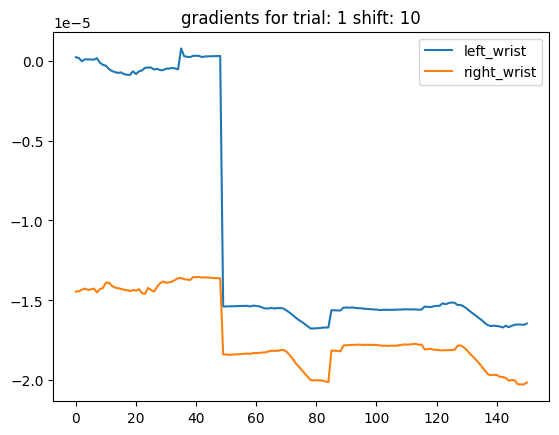

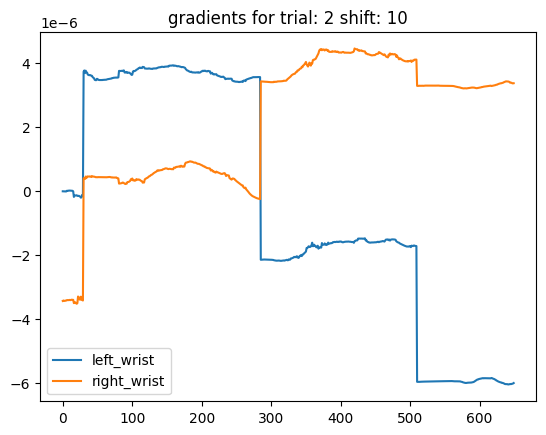

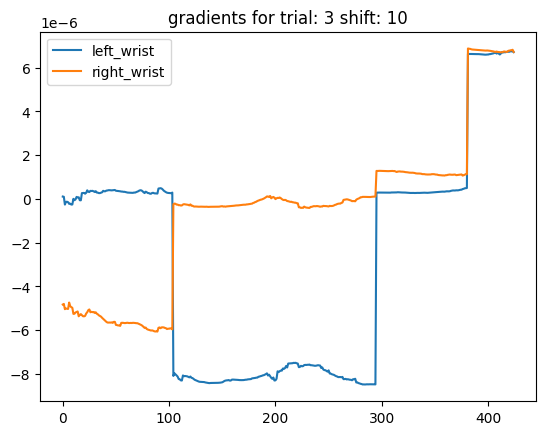

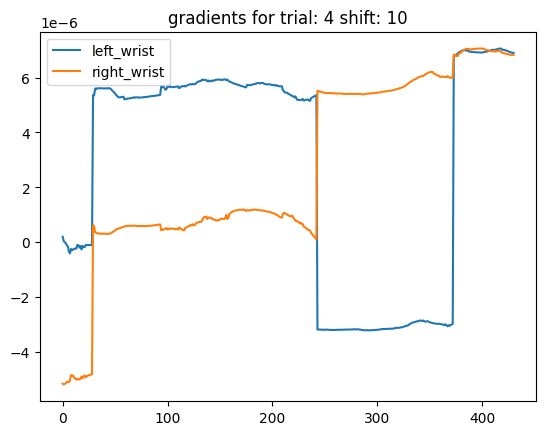

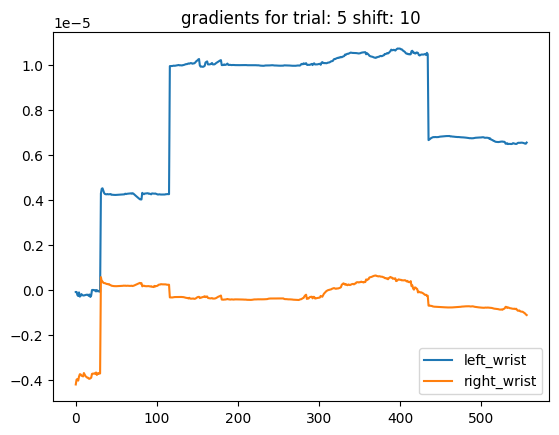

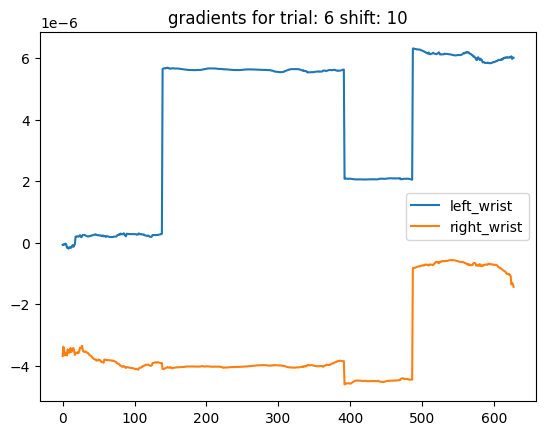

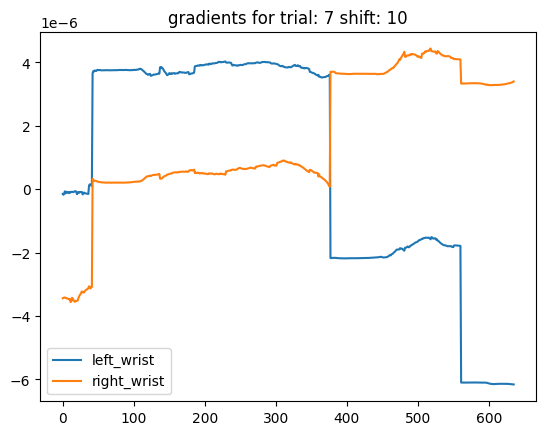

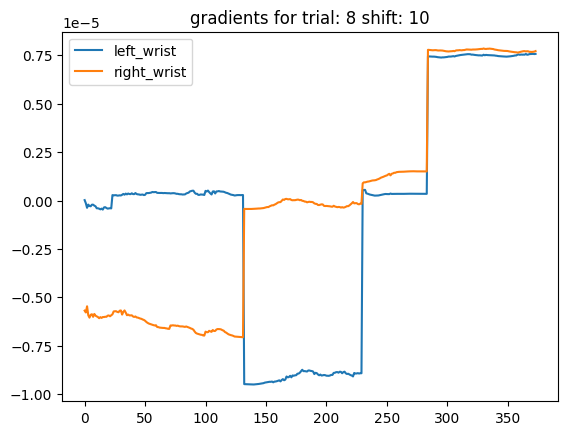

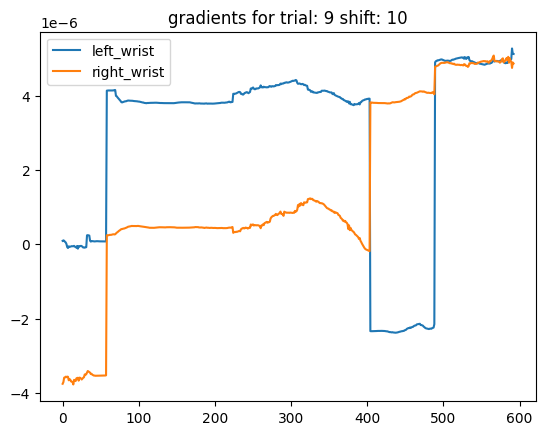

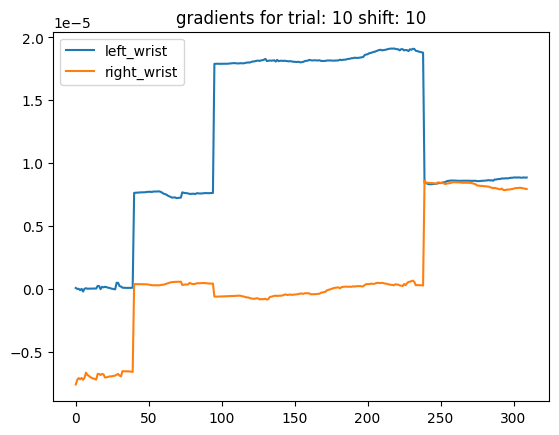

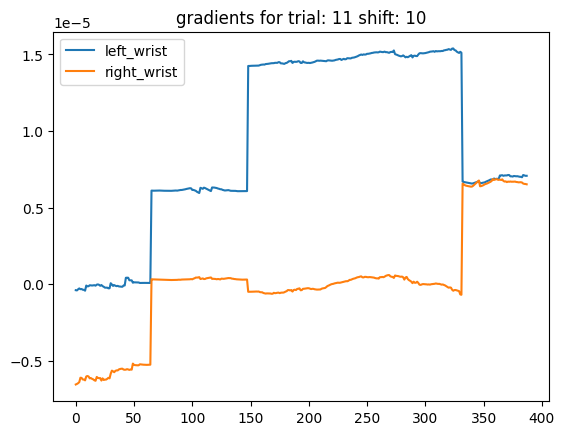

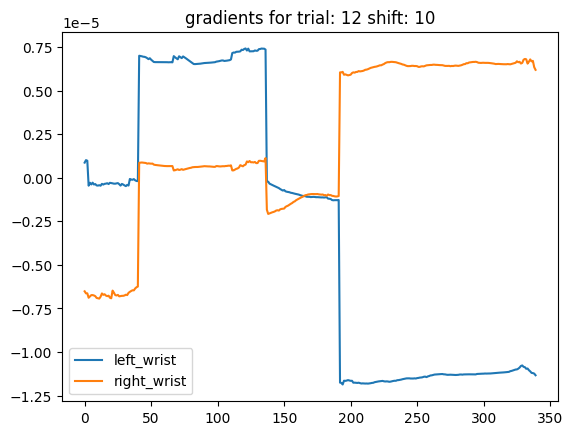

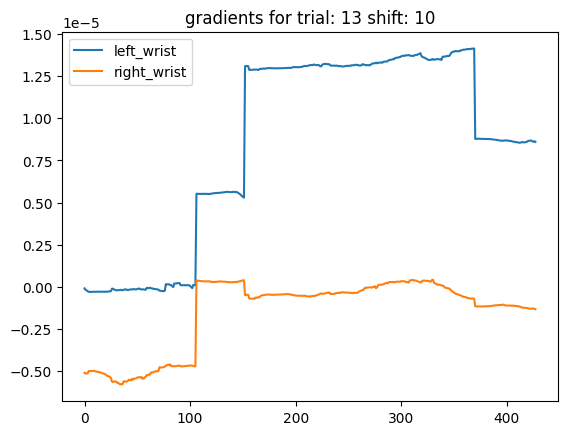

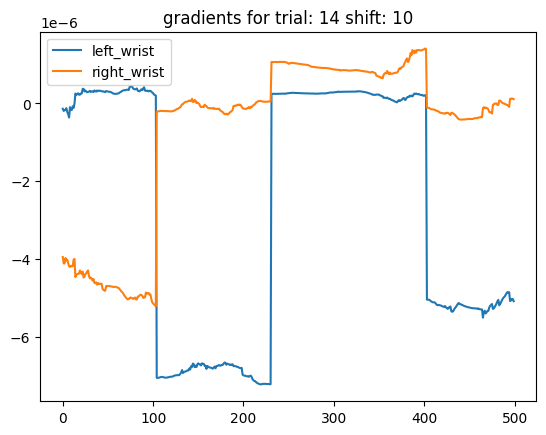

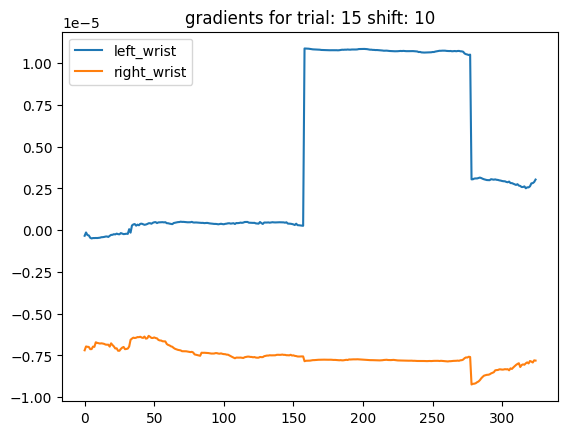

In [ ]:
for i in np.arange(1,16):
    shift = 10
    set_values = i
    k = 0+15*(set_values-1)
    print(shift,set_values,k)
    model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)+'_gates'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift)]
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    #print(X_train.columns)
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {'s_1_minus_10': 's_1',
                        's_2_minus_10': 's_2',
                        's_3_minus_10': 's_3',
                        's_4_minus_10': 's_4'}

    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.to_numpy()
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_sm.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_sm[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = y_hat.clone().detach().requires_grad_(True).float()
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()

    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    print('output shape:',output.shape)
    print('target shape:',y_tilda.shape)
    loss = loss_fn(output,y_tilda) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)
    #predictions_dict_sm[key] = input_gradients
    lWrist_x_gradient = input_gradients[:,21].numpy()
    rWrist_x_gradient = input_gradients[:,-10].numpy()
    plt.figure()
    plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
    plt.plot(lWrist_x_gradient,label='left_wrist')
    plt.plot(rWrist_x_gradient,label='right_wrist')
    plt.legend()
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_wrist_gradients.jpg'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)

In [ ]:
lWrist_x_gradient = input_gradients[:,21].numpy()
rWrist_x_gradient = input_gradients[:,-10].numpy()

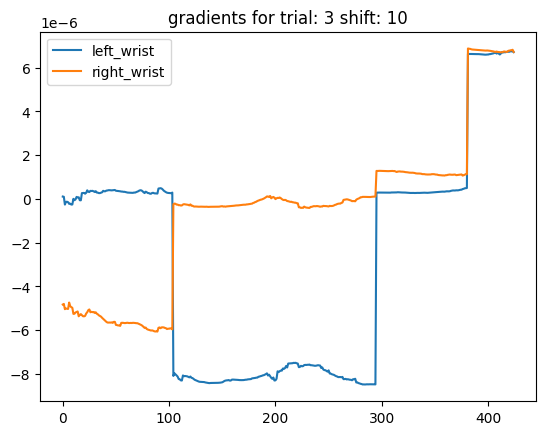

In [ ]:
plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
plt.plot(lWrist_x_gradient,label='left_wrist')
plt.plot(rWrist_x_gradient,label='right_wrist')
plt.legend()
plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_wrist_gradients.jpg'
plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/'+plot_name)


In [ ]:
np.sum(np.abs(rWrist_x_gradient) > np.abs(lWrist_x_gradient))

161

# SMH model

In [19]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial','s_1','s_2','s_3','s_4']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['H_headFront_x', 'H_headFront_y', 'H_headFront_z', 'H_neck_x',
       'H_neck_y', 'H_neck_z', 'H_lowerBack_x', 'H_lowerBack_y',
       'H_lowerBack_z', 'H_leftWrist_x', 'H_leftWrist_y', 'H_leftWrist_z',
       'H_leftShoulder_x', 'H_leftShoulder_y', 'H_leftShoulder_z',
       'H_leftElbow_x', 'H_leftElbow_y', 'H_leftElbow_z', 'nose_x', 'nose_y',
       'nose_z', 'headTop_x', 'headTop_y', 'headTop_z', 'neck_x', 'neck_y',
       'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z', 'lEar_x', 'lEar_y',
       'lEar_z', 'lShoulder_x', 'lShoulder_y', 'lShoulder_z', 'lElbow_x',
       'lElbow_y', 'lElbow_z', 'lWrist_x', 'lWrist_y', 'lWrist_z', 'lHip_x',
       'lHip_y', 'lHip_z', 'rEar_x', 'rEar_y', 'rEar_z', 'rShoulder_x',
       'rShoulder_y', 'rShoulder_z', 'rElbow_x', 'rElbow_y', 'rElbow_z',
       'rWrist_x', 'rWrist_y', 'rWrist_z', 'rHip_x', 'rHip_y', 'rHip_z'],
      dtype='object')

In [20]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 42
output_dim = 4
num_layers = 1
n_epochs =100
lr = 0.1

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)

In [ ]:
hidden_states_dict = {}
predictions_dict_mh = {}
for j in np.arange(1,16):
    for i in np.arange(10,151,step=10):
        shift = i
        set_values = j
        model_name = 's_m_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
      
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)



        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        
        
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        #torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
        

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()
        # Construct the key for the combination
        key = f"sm_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        predictions_dict_mh[key] = all_preds_array 

        print(model_name)
        print("Accuracy for each output state in",model_name)
        print(np.mean(accuracies))

Epoch 0, train loss: 0.8805989623069763, train acc: 0.6390368228849665
Epoch 10, train loss: 0.6238088011741638, train acc: 0.9860772976262934
Epoch 20, train loss: 0.6222189664840698, train acc: 0.9880553864881315
Epoch 30, train loss: 0.6213212013244629, train acc: 0.9897671941570299
Epoch 40, train loss: 0.6208311319351196, train acc: 0.990642118076689
Epoch 50, train loss: 0.6205485463142395, train acc: 0.9908323189287888
Epoch 60, train loss: 0.6202505230903625, train acc: 0.9915550821667681
Epoch 70, train loss: 0.620220422744751, train acc: 0.9914409616555082
Epoch 80, train loss: 0.6201062202453613, train acc: 0.9914790018259282
Epoch 90, train loss: 0.619750440120697, train acc: 0.9921637248934875
Epoch 0, train loss: 0.6195823550224304, train acc: 0.9925441265976872
Epoch 10, train loss: 0.6192823052406311, train acc: 0.9927723676202069
Epoch 20, train loss: 0.6191052794456482, train acc: 0.9930766889835666
Epoch 30, train loss: 0.6190136671066284, train acc: 0.99334297017650